In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
%matplotlib inline

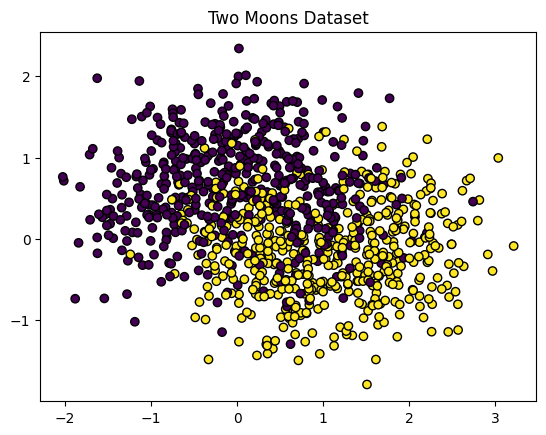

In [3]:
# Generate the two moons dataset
X, y = make_moons(n_samples=1000, noise=0.5, random_state=0)

y = np.where(y == 0, -1, 1)

# Visualize the dataset
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k')
plt.title('Two Moons Dataset')
plt.show()


In [4]:
# As you know we need to split the data into training, validation and test
x_train=X[0:800,:]
y_train=y[0:800].astype(int)

x_val=X[800:900,:]
y_val=y[800:900].astype(int)

x_test=X[900:1000,:]
y_test=y[900:1000].astype(int)

In [5]:
# Kernel functions remain the same
def linear_kernel(X, Y):
    """Compute the linear kernel between X and Y."""
    return np.dot(X, Y.T)

def polynomial_kernel(degree=3, coef0=1):
    def thunk(X,Y):
        """Compute the polynomial kernel between X and Y."""
        return (np.dot(X, Y.T) + coef0) ** degree
    return thunk

def rbf_kernel(gamma):
    def thunk(X,Y):
        """Compute the RBF (Gaussian) kernel between X and Y."""
        X_norm = np.sum(X ** 2, axis=1)
        Y_norm = np.sum(Y ** 2, axis=1)
        K = np.exp(-gamma * (
            X_norm[:, np.newaxis] + Y_norm[np.newaxis, :] - 2 * np.dot(X, Y.T)))
        return K
    return thunk



class SVM:

    def __init__(self, kernel, lr=1.0, C=1.0, epochs=1000):
        """
        Initialize the Kernel Ridge Regression model.

        Parameters:
        - kernel: string, specifies the kernel type ('linear', 'polynomial', 'rbf')
        - lr: float, learning_rate
        - C: float, hyperparameter
        - epochs: int, number of training epochs
        """
        self.kernel = kernel
        self.lr = lr
        self.C = C
        self.epochs = epochs
        self.alpha = None
        self.b = 0

    def fit(self, X, y):
        n_samples = X.shape[0]
        self.alpha = np.zeros(n_samples)
        K = self.kernel(X, X)
        
        for t in range(1, self.epochs+1):
            eta = self.C / float(t)  
            for i in range(n_samples):
                gradient_i = 1 - np.sum(self.alpha * y * y[i] * K[:, i])
                
                self.alpha[i] += eta * gradient_i
                
                # alpha_i = [0, C]
                if self.alpha[i] < 0:
                    self.alpha[i] = 0
                elif self.alpha[i] > self.C:
                    self.alpha[i] = self.C
        
        sv_indices = np.where((self.alpha > 1e-6) & (self.alpha < self.C - 1e-6))[0]
        if len(sv_indices) > 0:
            s = sv_indices[0]
        else:
            s_candidates = np.where(self.alpha > 1e-6)[0]
            s = s_candidates[0] if len(s_candidates) > 0 else 0
        
        self.X_train = X
        self.y_train = y
        self.b = y[s] - np.sum(self.alpha * y * K[:, s]) 

    def predict(self, X):
        K_test = self.kernel(X, self.X_train)
        decision = np.dot(K_test, self.alpha * self.y_train) + self.b
        y_pred = np.sign(decision)
        return y_pred


def decision_boundary_draw(model, X, y, step=200):
    """
    Draw the decision boundary of the trained SVM model.
    
    Parameters:
    - model: Trained SVM instance (with model.predict method)
    - X: Input data array of shape (N, 2) for plotting (assuming 2D data).
    - y: Labels array of shape (N,)
    - step: Resolution of the grid for plotting.
    """
    # Determine the range for the grid
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    
    # Create a mesh grid
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, step),
                         np.linspace(y_min, y_max, step))
    
    # Flatten and combine so we can predict on the entire grid at once
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    
    # Predict for all points in the grid
    Z = model.predict(grid_points)
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.figure(figsize=(8,6))
    # Use contourf to visualize the regions
    plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)

    # Draw the boundary line 
    plt.contour(xx, yy, Z, levels=[0], colors='k', linewidths=2)

    # Plot original points
    plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')

    plt.title("Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True)
    plt.show()



Test Accuracy: 0.8


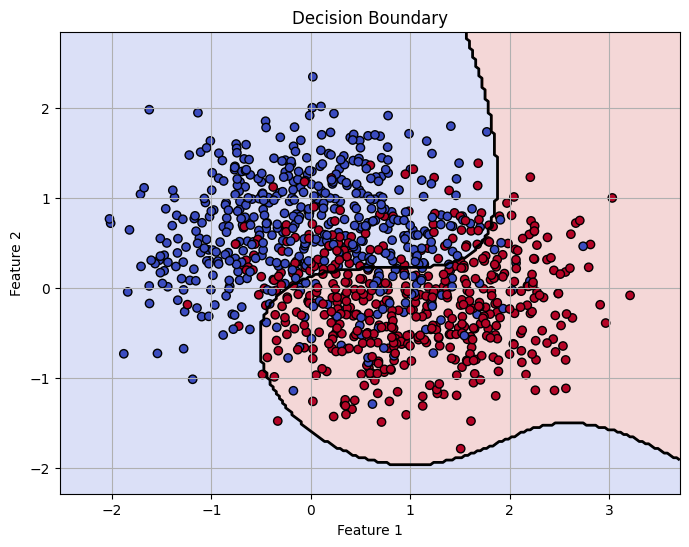

In [11]:
# Train and evaluate using poly_kernel
model = SVM(kernel=polynomial_kernel(degree=3, coef0=1), C=1.5, epochs=1000)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)
# Draw decision boundary 
decision_boundary_draw(model, X, y, step=200)

Test Accuracy: 0.81


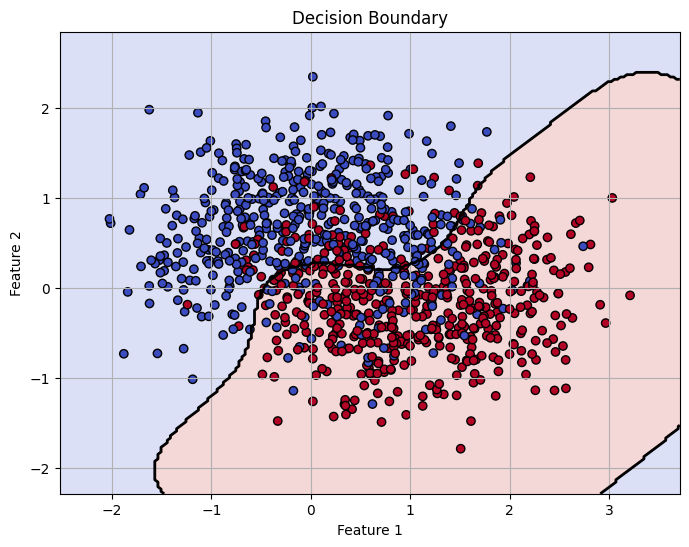

In [12]:
# Train and evaluate using rbf_kernel
model = SVM(kernel=rbf_kernel(gamma=1.0), C=5.0, epochs=200)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)
# Draw decision boundary 
decision_boundary_draw(model, X, y, step=200)